In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed      phase
Mean    -0.000003 -10.174578
Std      0.013941   3.978187
Var      0.000194  15.825972


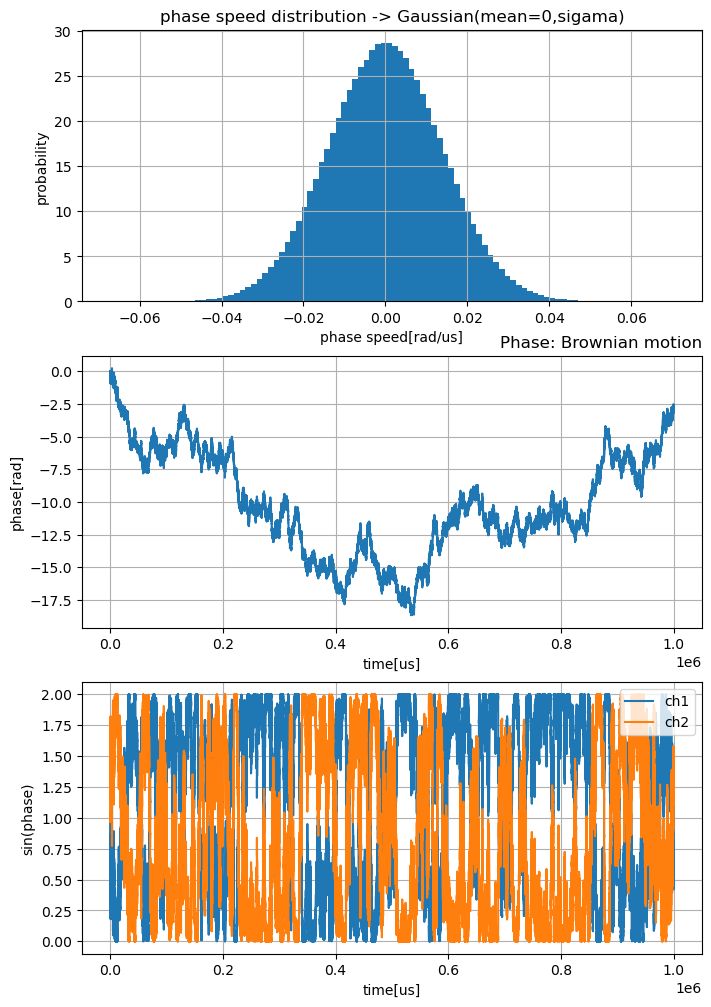

In [2]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

### method 1: 反馈1个sample  
每隔 time exposure 反馈一次  

In [3]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    

time_exposure=100 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],2)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],2)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #phase_measure_M1[i]=phase_M1[i,-1]
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1[i]#fb_weight(phase_measure_M1[i],time_exposure) # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

100%|██████████| 10000/10000 [00:00<00:00, 134640.39it/s]

      phase speed      phase  phase M1
Mean    -0.000003 -10.174578  0.000461
Std      0.013941   3.978187  0.147121
Var      0.000194  15.825972  0.021644


### Method 4：权重反馈

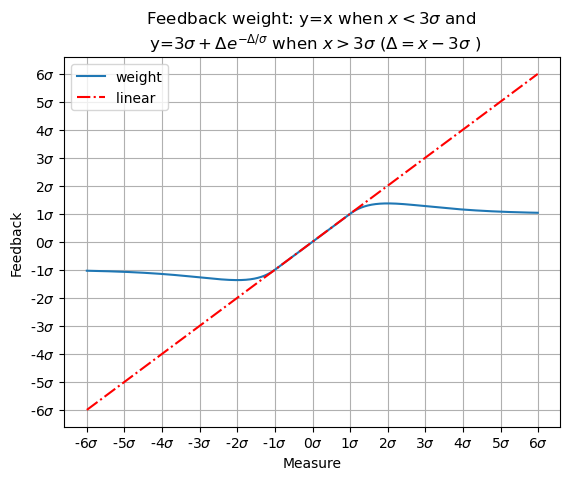

In [4]:
def fb_weight(measure, time_exposure,sigma=1):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #1 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure),label='weight')
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<3\\sigma$ and \n y=3$\\sigma+\\Delta e^{-\\Delta/\\sigma}$ when $x>3\\sigma$ ($\\Delta =x-3\\sigma$ )')
plt.show()

In [5]:
time_exposure=20 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M4=np.zeros_like(phase_speed_M4)
phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
fb0=0
sigma=1
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
    c0=phase_measure_M4[i]
    
    phase_fb_M4[i]=fb_weight(c0,time_exposure=time_exposure,sigma=2)


    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure

    phase_offest=phase_M4[i,-1]
phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
push_data(phase_out_M4,'phase M4')

100%|██████████| 50000/50000 [00:00<00:00, 80320.77it/s]

      phase speed      phase  phase M1  phase M4
Mean    -0.000003 -10.174578  0.000461 -0.001393
Std      0.013941   3.978187  0.147121  0.128510
Var      0.000194  15.825972  0.021644  0.016515


# 多次模拟

In [6]:
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 2: average feedback  
    method 3: average feedback with iteration  
    method 4: weighted feedback  
    """
    
    time_iter1=10 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    sig_ch1_exposure=np.zeros_like(phase_speed_M)
    sig_ch2_exposure=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        # _phase_i=np.ones_like(phase_M[i])*phase_M[i,-1]
        # sig_ch1_exposure[i]=get_sig_from_phase(_phase_i,1)
        # sig_ch2_exposure[i]=get_sig_from_phase(_phase_i,2)
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,time_exposure//10]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==2 or method==3:
                c0=phase_measure_M[i]
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1]-=phase_fb_M/time_exposure # 均匀反馈到下一个exposure时间
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure,sigma=1)
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1,time_exposure//10]-=phase_fb_M # 均匀反馈到下一个exposure时间

        if method==3:
            if i%time_iter1==0 and i!=0:
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i].sum())
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i].sum())
                phase_measure_M_it1=get_phase_from_count(ch1_measure,ch2_measure)
                c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
                phase_fb_M=np.sign(phase_measure_M_it1)*np.abs(c0)
                phase_speed_M[i:i+time_iter1]-=phase_fb_M/time_exposure/time_iter1

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M

out=simu_phase(phase_speed,time_exposure=20,method=4)
np.std(out)

100%|██████████| 50000/50000 [00:00<00:00, 91904.65it/s]


0.12482897415794168

## 不同曝光时间的变化

In [7]:
import allantools as at

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
RAND_NUM=1 # 随机模拟次数
time_axis=np.arange(0,1e5,1) #1us分辨率，len=1e5us  SR=1M
time_exposure=1000
RAND_SEED=2025
time_exposure_list=at.tau_generator(time_axis,rate=1,taus='decade')[1].astype(int)[1:-2]
m1_std_mean_list=np.zeros_like(time_exposure_list,dtype=float)
m1_std_err_list=np.zeros_like(time_exposure_list,dtype=float)
m4_std_mean_list=np.zeros_like(time_exposure_list,dtype=float)
m4_std_err_list=np.zeros_like(time_exposure_list,dtype=float)
for j,_time_exposure in enumerate(time_exposure_list):
    sig_ch1=np.zeros_like(time_axis)
    sig_ch2=np.zeros_like(time_axis)
    all_phase_speed=np.zeros((RAND_NUM,time_axis.shape[0]))
    all_phase=np.zeros((2,RAND_NUM,time_axis.shape[0]))
    for i in range(RAND_NUM):
        rng=np.random.default_rng(i+RAND_SEED)
        phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
        # phase_speed[0]=0
        phase=np.cumsum(phase_speed)
        all_phase_speed[i]=phase_speed
        all_phase[0,i]=simu_phase(phase_speed,time_exposure=_time_exposure,method=1)
        all_phase[1,i]=simu_phase(phase_speed,time_exposure=_time_exposure,method=4)

    down_sr=1
    time_axis_ds=time_axis[::down_sr] # 降采样时间轴
    all_std=np.zeros((2,time_axis_ds.size))
    m1_std_mean_list[j]=np.sqrt(np.mean(np.var(all_phase[0,:,::down_sr],axis=1)))
    m1_std_err_list[j]=np.std(np.var(all_phase[0,:,::down_sr],axis=1))
    m4_std_mean_list[j]=np.sqrt(np.mean(np.var(all_phase[1,:,::down_sr],axis=1)))
    m4_std_err_list[j]=np.std(np.var(all_phase[0,:,::down_sr],axis=1))


100%|██████████| 10/10 [00:00<00:00, 7919.76it/s]


In [8]:
# c1_,c2_,c3_,c4_='#f1ddbf', '#525e75', '#78938a', '#92ba92'
# c5,c1,c2,c3,c4="#d9042b","#730220","#03658c","#f29f05","#f27b50"
# # 把字体调大 
# plt.rcParams.update({
#     'font.size': 14,          # 全局默认字体大小
#     'axes.titlesize': 16,     # 标题字体大小
#     'axes.labelsize': 16,     # 坐标轴标签字体大小
#     'xtick.labelsize': 12,    # x轴刻度字体大小
#     'ytick.labelsize': 12,    # y轴刻度字体大小
#     'legend.fontsize': 14     # 图例字体大小
# })
# bandwith_tau=1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))

# phase_var_limit=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
# adv_up=phase_var_limit*2
# adv_low=phase_var_limit*1e-5 
# phase_diffusion=(PHASE_SEEPD*np.sqrt(time_axis))**2
# plt.figure(figsize=(8,5),dpi=200)
# plt.plot(time_axis,phase_diffusion,'-.',label='Phase diffusion',color=c3)
# plt.plot(time_axis[1:],1/(2*SIG_AMP*time_axis[1:]),'-.',label='Shot noise limit',color=c4)
# # plt.plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',color=c5)
# plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')
# plt.plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',color=c2)
# # plt.plot(time_exposure_list[:-1],m4_std_mean_list_15[:-1]**2,'.',color=c1)
# plt.loglog(time_axis,1/crb(time_axis,with_prior=True)+phase_diffusion,'-',color=c2,label='Estimation with prior')
# # plt.vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
# plt.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
# plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# # 区域
# plt.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
# # plt.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
# # plt.text(bandwith_tau, 40e-4, '$τ_{opt}$', ha='center', va='bottom', fontsize=14,color=c2_)
# plt.xscale('log')
# # plt.yscale('log')
# plt.yscale('linear')
# plt.ylim(25e-4,1)
# plt.ylim(0.9e-2,2e-2)
# plt.xlim(1,5e3)
# plt.legend(loc='lower right')
# plt.grid(alpha=0.7)
# plt.xlabel('Integration time / us')
# plt.ylabel('Var($\\phi$) / rad$^2$')
# plt.tight_layout()
# plt.savefig('Fig2_simu.pdf',dpi=1000,bbox_inches='tight')
# # text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
# # text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# # plt.title(text0+text1)

# plt.show()

In [9]:
def crb(tau,with_prior):
    mu=SIG_AMP*2
    V=GAMMY
    sigma=PHASE_SEEPD
    D=sigma*sigma
    ka=0
    a=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
    i_eff=mu*tau*np.exp(-D*tau)
    i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
    i_prio=1/(sigma*sigma*tau+a)
    if with_prior:
        return i_prio+i_eff
    else:
        return i_eff

c1_,c2_,c3_,c4_='#f1ddbf', '#525e75', '#78938a', '#92ba92'
c5,c1,c2,c3,c4="#d9042b","#730220","#03658c","#f29f05","#f27b50"


### 正文无模拟点

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/162803057.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/1411969615.py:9: RuntimeWarning: divide by zero encountered in divide
  i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/162803057.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')


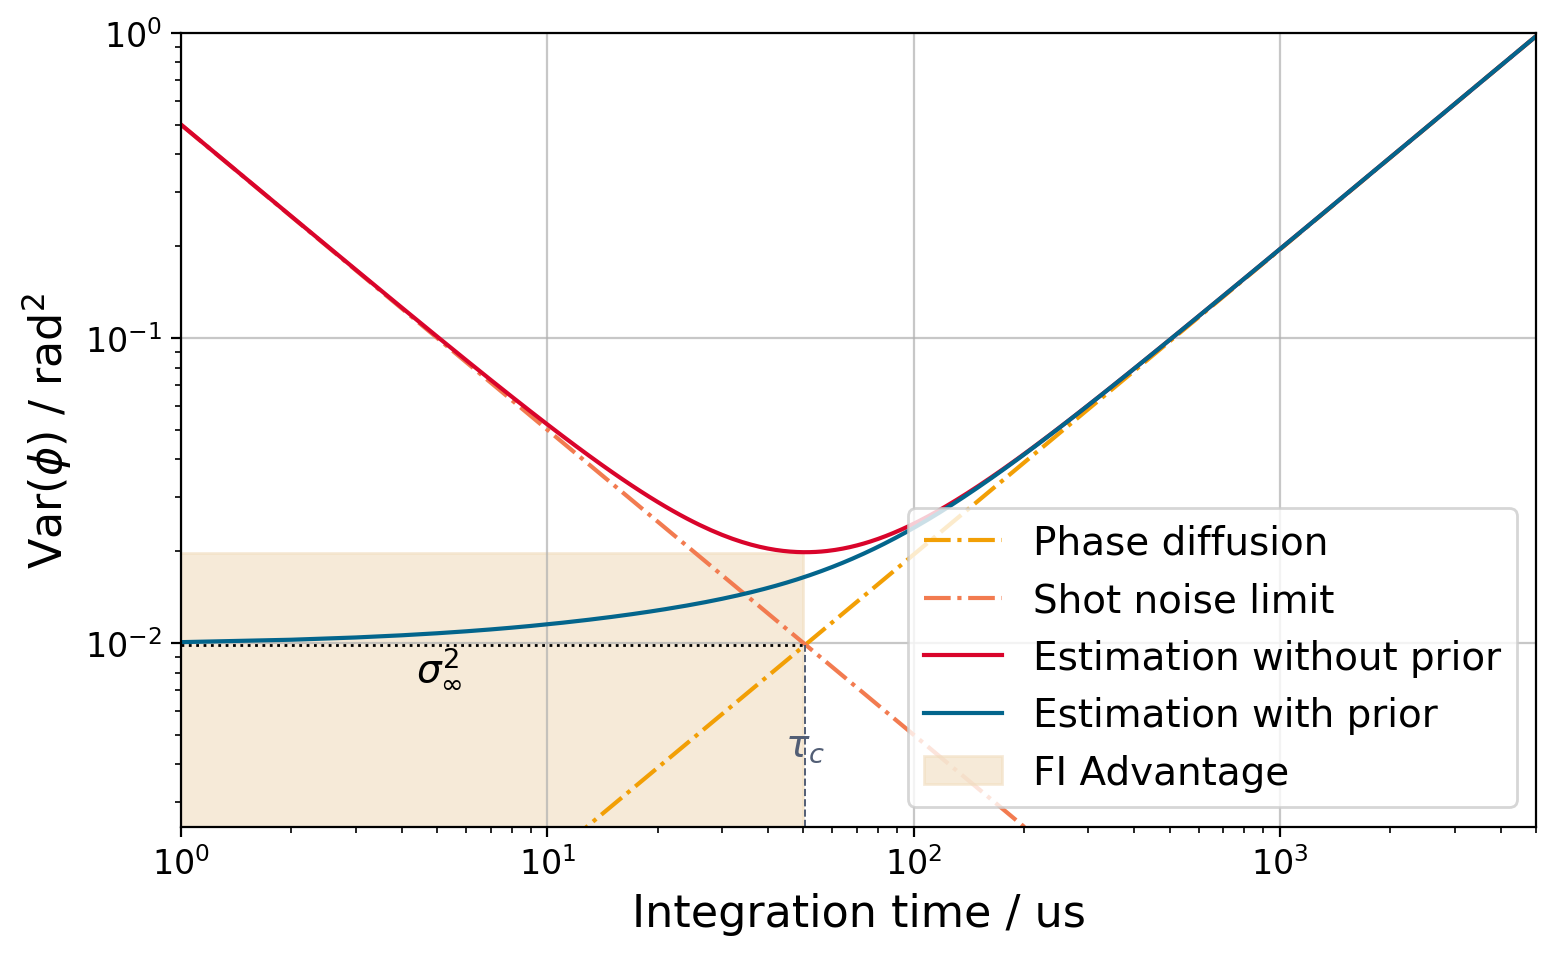

In [10]:
# 把字体调大 
plt.rcParams.update({
    'font.size': 14,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 12,    # x轴刻度字体大小
    'ytick.labelsize': 12,    # y轴刻度字体大小
    'legend.fontsize': 14     # 图例字体大小
})
bandwith_tau=1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))

phase_var_limit=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
adv_up=phase_var_limit*2
adv_low=phase_var_limit*1e-5 
phase_diffusion=(PHASE_SEEPD*np.sqrt(time_axis))**2
plt.figure(figsize=(8,5),dpi=200)
plt.plot(time_axis,phase_diffusion,'-.',label='Phase diffusion',color=c3)
plt.plot(time_axis[1:],1/(2*SIG_AMP*time_axis[1:]),'-.',label='Shot noise limit',color=c4)
# plt.plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',label='Without prior',color=c5)
plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')
# plt.plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',label='With prior',color=c2)
plt.loglog(time_axis,1/crb(time_axis,with_prior=True)+phase_diffusion,'-',color=c2,label='Estimation with prior')
# plt.vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
plt.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# 区域
plt.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
plt.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
plt.text(bandwith_tau, 40e-4, '$τ_{c}$', ha='center', va='bottom', fontsize=14,color=c2_)
plt.xscale('log')
plt.yscale('log')
plt.ylim(25e-4,1)
plt.xlim(1,5e3)
plt.legend(loc='lower right')
plt.grid(alpha=0.7)
plt.xlabel('Integration time / us')
plt.ylabel('Var($\\phi$) / rad$^2$')
plt.tight_layout()
plt.savefig('Fig2_simu.pdf',dpi=1000,bbox_inches='tight')
# text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
# text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# plt.title(text0+text1)

plt.show()

### SM 带模拟点

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/1560546566.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/1411969615.py:9: RuntimeWarning: divide by zero encountered in divide
  i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/1560546566.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')


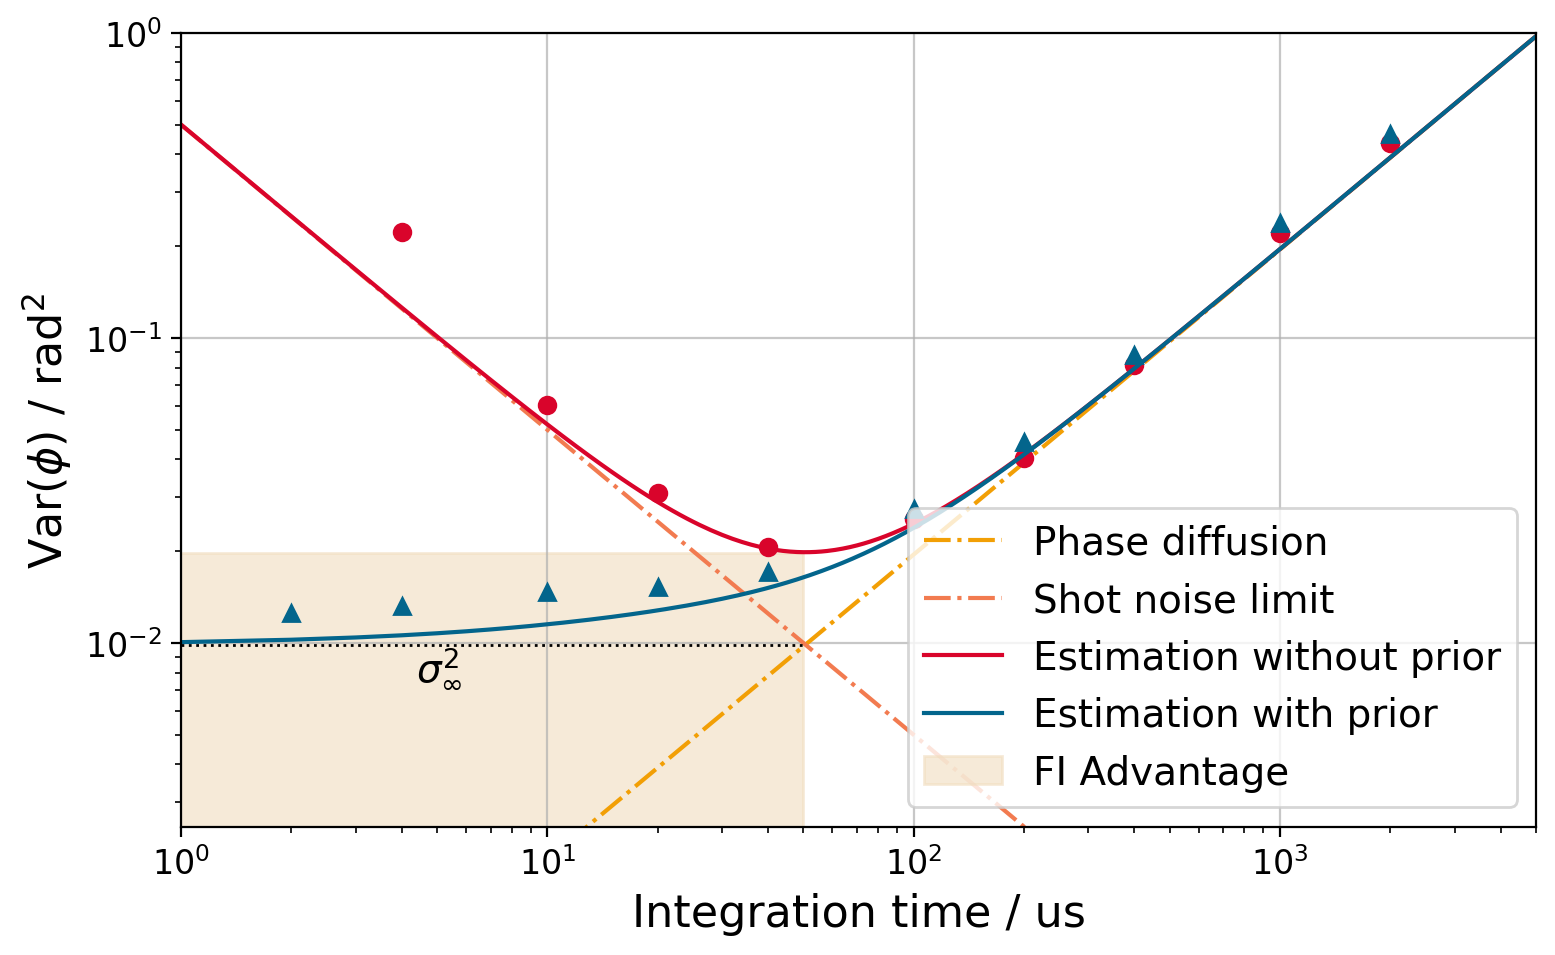

In [11]:
# 把字体调大 
plt.rcParams.update({
    'font.size': 14,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 12,    # x轴刻度字体大小
    'ytick.labelsize': 12,    # y轴刻度字体大小
    'legend.fontsize': 14     # 图例字体大小
})
bandwith_tau=1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))

phase_var_limit=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
adv_up=phase_var_limit*2
adv_low=phase_var_limit*1e-5 
phase_diffusion=(PHASE_SEEPD*np.sqrt(time_axis))**2
plt.figure(figsize=(8,5),dpi=200)
plt.plot(time_axis,phase_diffusion,'-.',label='Phase diffusion',color=c3)
plt.plot(time_axis[1:],1/(2*SIG_AMP*time_axis[1:]),'-.',label='Shot noise limit',color=c4)
plt.plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',color=c5)
plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')
plt.plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',color=c2)
plt.loglog(time_axis,1/crb(time_axis,with_prior=True)+phase_diffusion,'-',color=c2,label='Estimation with prior')
# plt.vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
plt.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
plt.text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# 区域
plt.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
# plt.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
# plt.text(bandwith_tau, 40e-4, '$τ_{opt}$', ha='center', va='bottom', fontsize=14,color=c2_)
plt.xscale('log')
plt.yscale('log')
plt.ylim(25e-4,1)
plt.xlim(1,5e3)
plt.legend(loc='lower right')
plt.grid(alpha=0.7)
plt.xlabel('Integration time / us')
plt.ylabel('Var($\\phi$) / rad$^2$')
plt.tight_layout()
plt.savefig('Fig2_simu.pdf',dpi=1000,bbox_inches='tight')
# text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
# text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# plt.title(text0+text1)

plt.show()

100%|██████████| 100000/100000 [00:01<00:00, 79073.94it/s]
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/1411969615.py:9: RuntimeWarning: divide by zero encountered in divide
  i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_6587/1121680082.py:29: RuntimeWarning: divide by zero encountered in divide
  axs[1].loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')


Phase diffusion:1.95e-04 rad^2/us
amptitude of light in single SNSPD:1.00e+06 cps


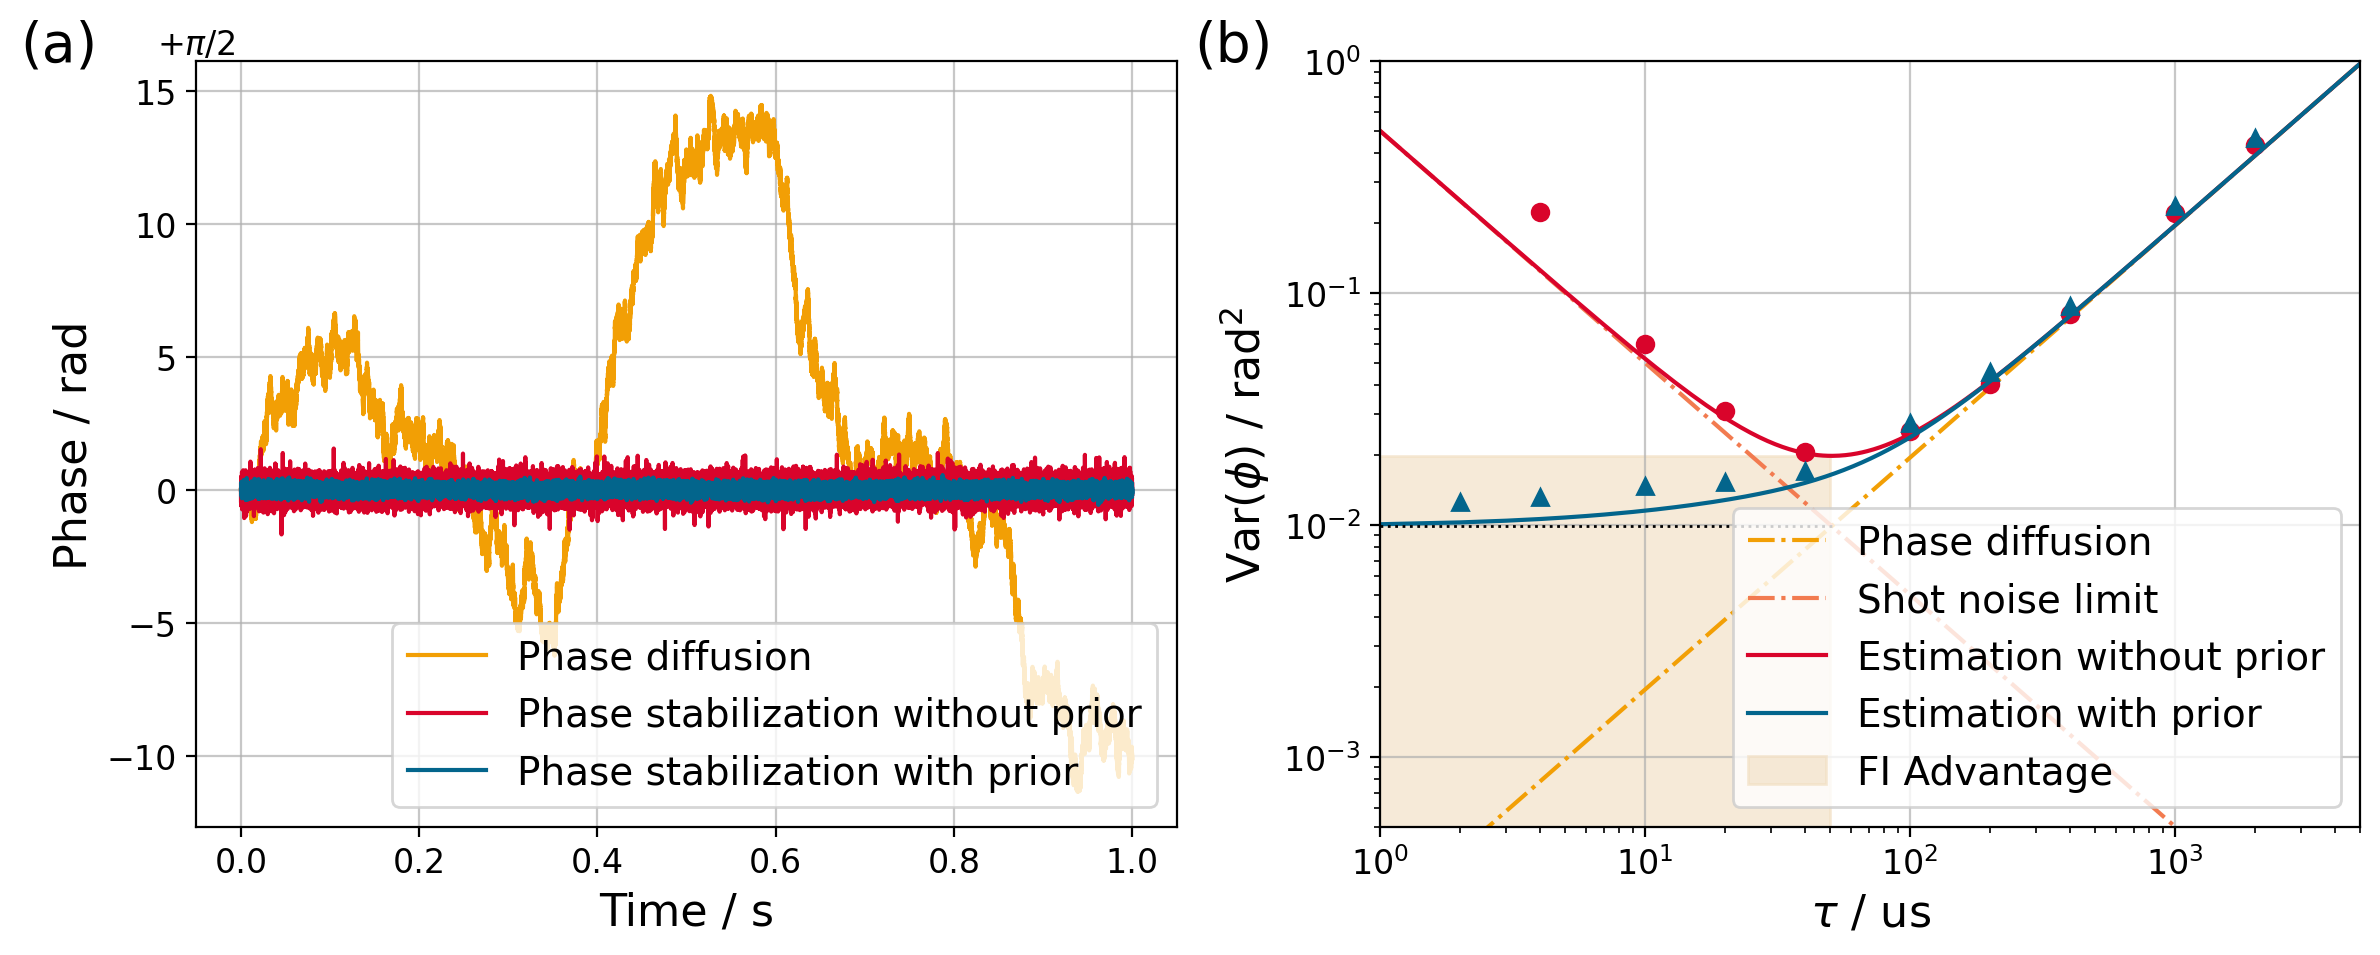

In [13]:
time_axis_0=np.arange(0,1e6,1) #1us分辨率，len=1e5us  SR=1M
_time_exposure=10
sig_ch1=np.zeros_like(time_axis_0)
sig_ch2=np.zeros_like(time_axis_0)

rng=np.random.default_rng(RAND_SEED+7)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis_0.shape)
# phase_speed[0]=0
phase=np.cumsum(phase_speed)
phase_m1=simu_phase(phase_speed,time_exposure=_time_exposure,method=1)
phase_m4=simu_phase(phase_speed,time_exposure=_time_exposure,method=4)

fig,axs=plt.subplots(1,2,figsize=(12,5),dpi=200)
axs[0].plot(time_axis_0*1e-6,phase,label='Phase diffusion',color=c3)
axs[0].plot(time_axis_0*1e-6,phase_m1,label='Phase stabilization without prior',color=c5)
axs[0].plot(time_axis_0*1e-6,phase_m4,label='Phase stabilization with prior',color=c2)
## x 轴单位缩放到s
axs[0].set_xlabel('Time / s')
axs[0].set_ylabel('Phase / rad')
## 在y轴上方增加文字 +pi/2
axs[0].text(0, 1.0, '$+\\pi/2$', transform=axs[0].transAxes, ha='center', va='bottom', fontsize=12, color='k')
# axs[0].set_ylim(-4,6.5)
axs[0].legend(loc='lower right')
axs[0].grid(alpha=0.7)

axs[1].plot(time_axis,phase_diffusion,'-.',label='Phase diffusion',color=c3)
axs[1].plot(time_axis[1:],1/(2*SIG_AMP*time_axis[1:]),'-.',label='Shot noise limit',color=c4)
axs[1].plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',color=c5)
axs[1].loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation without prior')
axs[1].plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',color=c2)
axs[1].loglog(time_axis,1/crb(time_axis,with_prior=True)+phase_diffusion,'-',color=c2,label='Estimation with prior')
# axs[1].vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
axs[1].hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
# axs[1].text(bandwith_tau*1e-1, phase_var_limit, '$\sigma_{\infty}^2$', ha='center', va='top', fontsize=14,color='k')

# 区域
axs[1].fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='FI Advantage')
# axs[1].vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
# axs[1].text(bandwith_tau, 40e-4, '$τ_{opt}$', ha='center', va='bottom', fontsize=14,color=c2_)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(5e-4,1)
axs[1].set_xlim(1,5e3)
axs[1].legend(loc='lower right')
axs[1].grid(alpha=0.7)
axs[1].set_xlabel('$\\tau$ / us')
axs[1].set_ylabel('Var($\\phi$) / rad$^2$')
# 左上角画出(a)(b)
axs[0].text(-0.18, 1, '(a)', transform=axs[0].transAxes, fontsize=20)
axs[1].text(-0.19, 1, '(b)', transform=axs[1].transAxes, fontsize=20)

plt.tight_layout()
plt.savefig('SM_simu_0.pdf',dpi=1000,bbox_inches='tight')
print('Phase diffusion:{:.2e} rad^2/us'.format(PHASE_SEEPD**2))
print('amptitude of light in single SNSPD:{:.2e} cps'.format(SIG_AMP*1e6))

### PPT

/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_18677/1411969615.py:9: RuntimeWarning: divide by zero encountered in divide
  i_prio=1/(sigma*sigma*tau+ka/mu/V/V)
/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_18677/4059714403.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation')


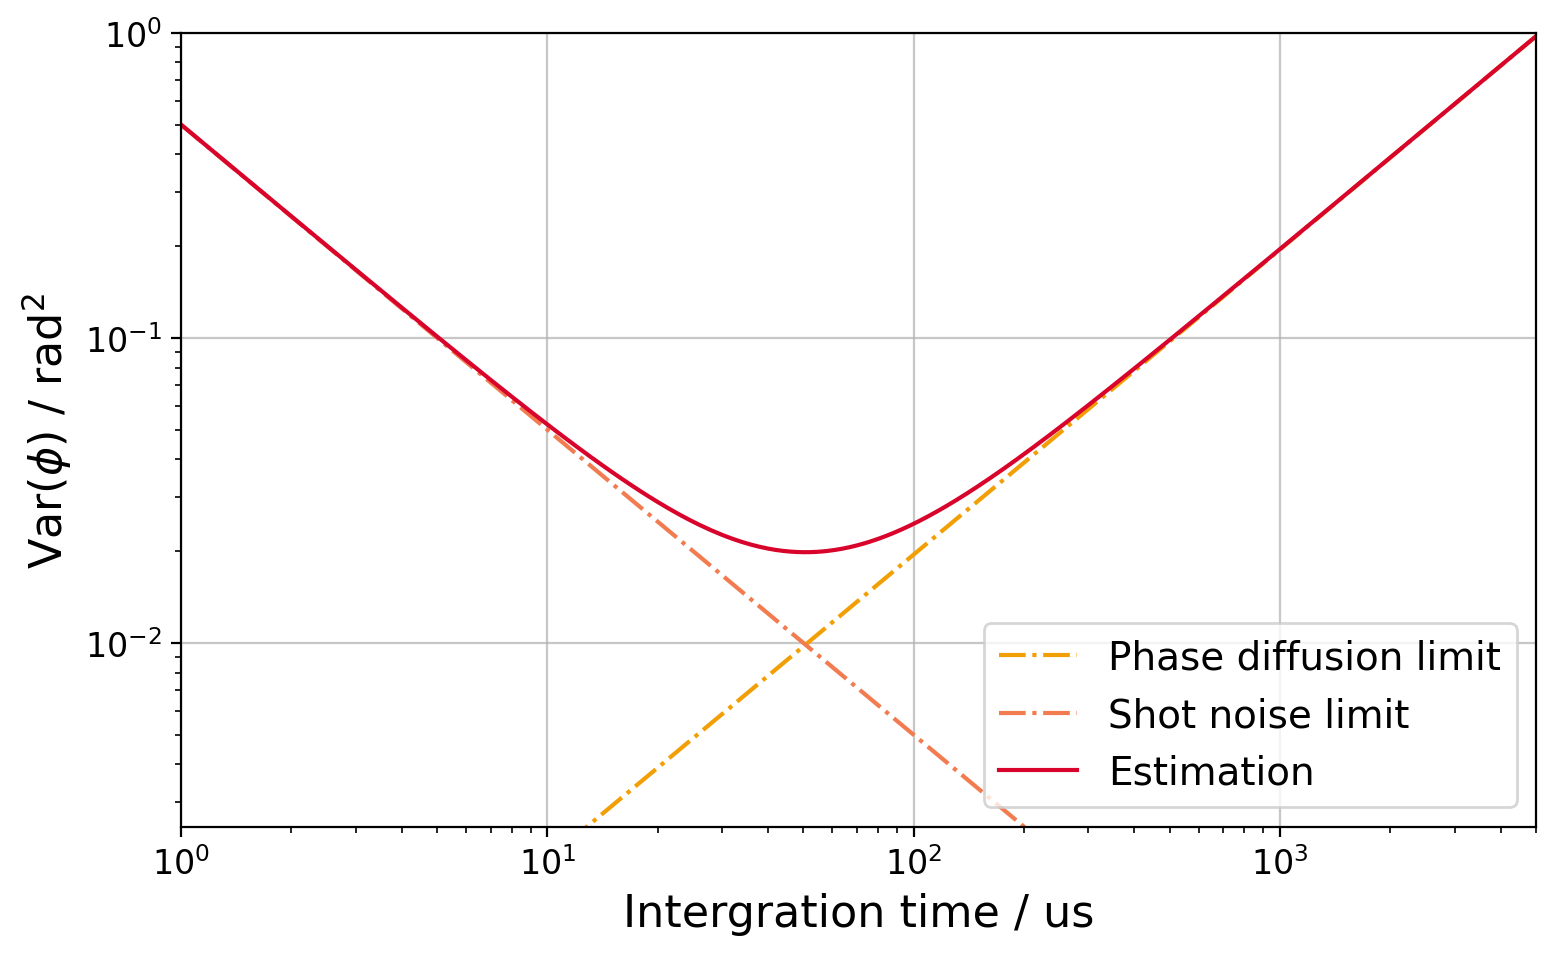

In [113]:
# 把字体调大 
plt.rcParams.update({
    'font.size': 14,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 12,    # x轴刻度字体大小
    'ytick.labelsize': 12,    # y轴刻度字体大小
    'legend.fontsize': 14     # 图例字体大小
})
bandwith_tau=1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP))

phase_var_limit=PHASE_SEEPD/np.sqrt(2*SIG_AMP)
adv_up=phase_var_limit*2
adv_low=phase_var_limit*1e-5 
phase_diffusion=(PHASE_SEEPD*np.sqrt(time_axis))**2
plt.figure(figsize=(8,5),dpi=200)
plt.plot(time_axis,phase_diffusion,'-.',label='Phase diffusion limit',color=c3)
plt.plot(time_axis[1:],1/(2*SIG_AMP*time_axis[1:]),'-.',label='Shot noise limit',color=c4)
# plt.plot(time_exposure_list[1:-1],m1_std_mean_list[1:-1]**2,'o',label='Without prior',color=c5)
plt.loglog(time_axis,1/crb(time_axis,with_prior=False)+phase_diffusion,'-',color=c5,label='Estimation')
# plt.plot(time_exposure_list[:-1],m4_std_mean_list[:-1]**2,'^',label='With prior',color=c2)
# plt.loglog(time_axis,1/crb(time_axis,with_prior=True)+phase_diffusion,'-',color=c2,label='Estimation with prior')
# # plt.vlines(bandwith_tau,25e-4,1,linestyles='--',label='Bandwidth',color='C1')
# plt.hlines(phase_var_limit,1,bandwith_tau,linestyles=':',color='k',linewidth=1)
# plt.text(bandwith_tau*1e-1, phase_var_limit, '$Var_{mini}(\\hat\\phi)$', ha='center', va='top', fontsize=14,color='k')

# 区域
# plt.fill_between(time_axis[time_axis<=bandwith_tau],adv_low,adv_up,color=c1_,alpha=0.6,label='Advantage region')
# plt.vlines(bandwith_tau, 25e-4, phase_var_limit, linestyles='--', color=c2_,linewidth=0.7)
# plt.text(bandwith_tau, 40e-4, '$τ_{opt}$', ha='center', va='bottom', fontsize=14,color=c2_)
plt.xscale('log')
plt.yscale('log')
plt.ylim(25e-4,1)
plt.xlim(1,5e3)
plt.legend(loc='lower right')
plt.grid(alpha=0.7)
plt.xlabel('Intergration time / us')
plt.ylabel('Var($\\phi$) / rad$^2$')
plt.tight_layout()
# plt.savefig('Fig2_simu.pdf',dpi=1000,bbox_inches='tight')
# text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
# text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# plt.title(text0+text1)

plt.show()

100%|██████████| 500000/500000 [00:06<00:00, 81456.56it/s]


phase var:0.0019
m1 phase var:0.0211, std0.1454
m4 phase var:0.0117, std0.1082


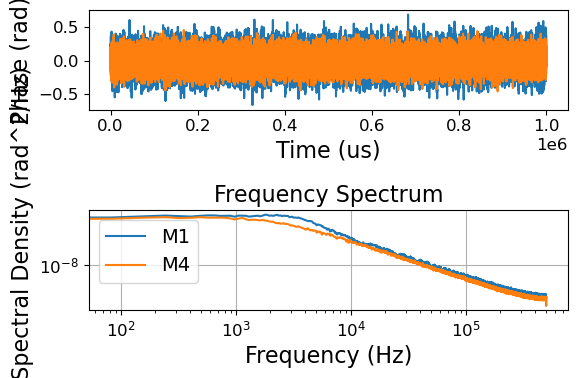

In [114]:
m1_exposure=80
m4_exposure=2
RAND_SEED=25
rng=np.random.default_rng(RAND_SEED)
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1e5us  SR=1M
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
from scipy.signal import welch
ori_phase=np.cumsum(phase_speed)
m1_phase=simu_phase(phase_speed,time_exposure=m1_exposure,method=1)
# m1_phase_in_m4=simu_phase(phase_speed,time_exposure=40,method=1)
m4_phase=simu_phase(phase_speed,time_exposure=m4_exposure,method=4)
f_ori, Pxx_ori = welch(ori_phase,fs=1e6,nperseg=1024*12)
f_m1, Pxx_m1 = welch(m1_phase,fs=1e6,nperseg=1024*12)
# f_m1_in_m4, Pxx_m1_in_m4 = welch(m1_phase_in_m4,fs=1e6,nperseg=1024*12)
f_m4, Pxx_m4 = welch(m4_phase,fs=1e6,nperseg=1024*12)
print('phase var:{:.4f}'.format(_time_exposure*PHASE_SEEPD**2))
print('m1 phase var:{:.4f}, std{:.4f}'.format(np.var(m1_phase),np.std(m1_phase)))
print('m4 phase var:{:.4f}, std{:.4f}'.format(np.var(m4_phase),np.std(m4_phase)))

plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
# 时域
# plt.plot(time_axis,ori_phase,label='origin')
plt.plot(time_axis,m1_phase,label='M1 best')
plt.plot(time_axis,m4_phase,label='M4 best')
# plt.plot(time_axis,m1_phase_in_m4,label='M1 in m4 time')
plt.xlabel('Time (us)')
plt.ylabel('Phase (rad)')
# 频谱
plt.subplot(2,1,2)
# plt.plot(f_ori,Pxx_ori,label='phase no detection noise')
plt.plot(f_m1,Pxx_m1,label='M1')
plt.plot(f_m4,Pxx_m4,label='M4')
# plt.plot(f_m1_in_m4,Pxx_m1_in_m4,label=' M1 in m4 time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (rad^2/Hz)')
plt.title('Frequency Spectrum')
plt.tight_layout()
plt.show()


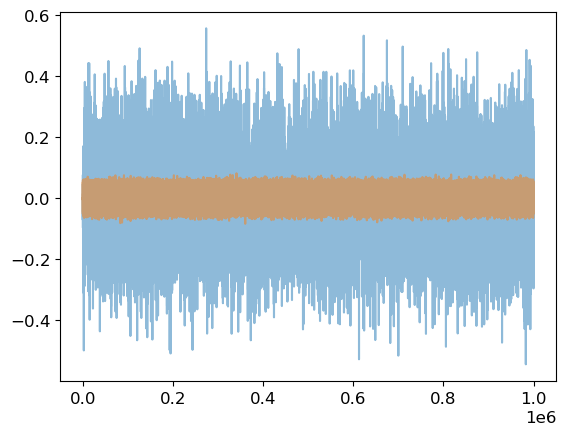

In [115]:
# plt.plot(np.diff(ori_phase),alpha=0.5)
plt.plot(np.diff(m1_phase),alpha=0.5)
plt.plot(np.diff(m4_phase),alpha=0.5)
# plt.plot(np.diff(m1_phase_in_m4),alpha=0.5)

## 不同计数率

In [116]:
import allantools as at

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=2 # 10sample/us  cps=10M
RAND_NUM=5 # 随机模拟次数
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1e5us  SR=1M
time_exposure=1000
RAND_SEED=2025
amp_list=[1,2,4,6,8,10,20,40]
_best_exposure=np.array([160, 100,  80,  50,  40,  25,  16])
m1_std_mean_list=np.zeros_like(amp_list,dtype=float)
m1_std_err_list=np.zeros_like(amp_list,dtype=float)
m4_std_mean_list=np.zeros_like(amp_list,dtype=float)
m4_std_err_list=np.zeros_like(amp_list,dtype=float)
for j,_amp in enumerate(amp_list):
    SIG_AMP=_amp
    sig_ch1=np.zeros_like(time_axis)
    sig_ch2=np.zeros_like(time_axis)
    all_phase_speed=np.zeros((RAND_NUM,time_axis.shape[0]))
    all_phase=np.zeros((2,RAND_NUM,time_axis.shape[0]))
    for i in range(RAND_NUM):
        rng=np.random.default_rng(i+RAND_SEED)
        phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
        # phase_speed[0]=0
        phase=np.cumsum(phase_speed)
        all_phase_speed[i]=phase_speed
        all_phase[0,i]=simu_phase(phase_speed,time_exposure=10,method=1)
        # try:
        #     # _best_exposure=int((1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))//2*2)
            
        # except:
        #     _best_exposure=int((1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))//100*100)
        #     all_phase[0,i]=simu_phase(phase_speed,time_exposure=_best_exposure,method=1)
        all_phase[1,i]=simu_phase(phase_speed,time_exposure=10,method=4)

    down_sr=1
    time_axis_ds=time_axis[::down_sr] # 降采样时间轴
    all_std=np.zeros((2,time_axis_ds.size))
    m1_std_mean_list[j]=np.sqrt(np.mean(np.var(all_phase[0,:,::down_sr],axis=1)))
    m1_std_err_list[j]=np.std(np.var(all_phase[0,:,::down_sr],axis=1))
    m4_std_mean_list[j]=np.sqrt(np.mean(np.var(all_phase[1,:,::down_sr],axis=1)))
    m4_std_err_list[j]=np.std(np.var(all_phase[0,:,::down_sr],axis=1))


 58%|█████▊    | 57978/100000 [00:00<00:00, 73199.30it/s]


KeyboardInterrupt: 

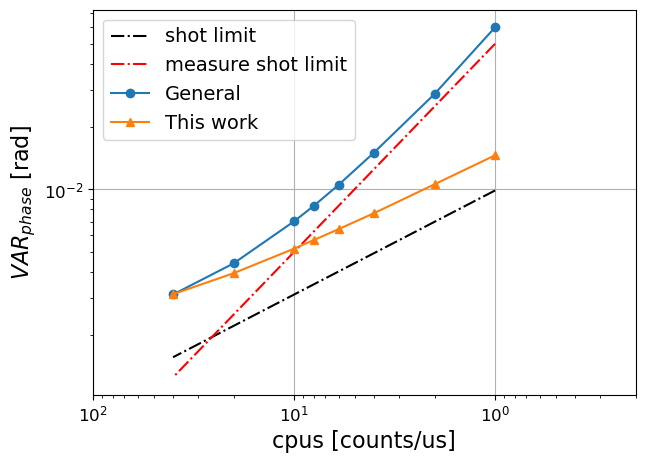

In [ ]:
amp_list=np.array(amp_list)
amp_list_arry=np.linspace(amp_list.min(),amp_list.max(),1000)
equal_time_list=1/(PHASE_SEEPD*np.sqrt(2*amp_list_arry))

plt.figure(figsize=(7,5))
plt.plot(amp_list_arry,1/(2*equal_time_list*amp_list_arry),'k-.',label='shot limit')
plt.plot(amp_list_arry,1/(2*10*amp_list_arry),'r-.',label='measure shot limit')
plt.plot(amp_list,m1_std_mean_list**2,'o-',label='General')
plt.plot(amp_list,m4_std_mean_list**2,'^-',label='This work')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-2,2)
plt.xlim(1e2,0.2)
plt.legend()
plt.grid()
plt.xlabel('cpus [counts/us]')
plt.ylabel('$VAR_{phase}$ [rad]')
text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
# plt.title(text0+text1)
plt.show()

In [ ]:
1/np.sqrt(2*amp_list_arry)

array([2.23606798, 2.13288076, 2.04277564, 1.96320316, 1.89225927,
       1.8284894 , 1.77076063, 1.71817568, 1.67001339, 1.62568667,
       1.58471203, 1.54668723, 1.5112745 , 1.47818787, 1.44718334,
       1.41805133, 1.39061062, 1.36470367, 1.34019271, 1.31695672,
       1.29488886, 1.27389443, 1.25388913, 1.23479767, 1.21655251,
       1.19909292, 1.18236411, 1.16631647, 1.15090501, 1.13608876,
       1.12183038, 1.10809571, 1.09485346, 1.08207489, 1.06973356,
       1.05780509, 1.04626696, 1.03509834, 1.02427991, 1.01379376,
       1.0036232 , 0.99375273, 0.98416787, 0.9748551 , 0.9658018 ,
       0.95699613, 0.948427  , 0.94008402, 0.9319574 , 0.92403796,
       0.91631704, 0.90878647, 0.90143858, 0.89426608, 0.8872621 ,
       0.88042016, 0.8737341 , 0.86719809, 0.86080659, 0.85455436,
       0.84843642, 0.84244802, 0.83658466, 0.83084205, 0.82521609,
       0.81970289, 0.81429874, 0.80900008, 0.80380353, 0.79870585,
       0.79370394, 0.78879485, 0.78397573, 0.77924387, 0.77459

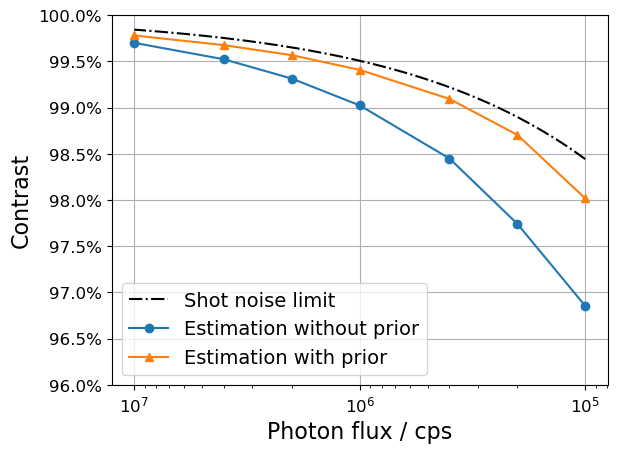

In [ ]:

plt.plot(amp_list_arry*1e6,100*np.cos(1/np.sqrt(2*equal_time_list*amp_list_arry)),'k-.',label='Shot noise limit')
plt.plot(amp_list*1e6,100*np.cos(m1_std_mean_list),'o-',label='Estimation without prior')
# plt.plot(amp_list_arry*1e6,100*np.cos(1.414/np.sqrt(2*equal_time_list*amp_list_arry)),'k-.',label='Shot noise limit')
plt.plot(amp_list*1e6,100*np.cos(m4_std_mean_list),'^-',label='Estimation with prior')
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Photon flux / cps')
plt.xscale('log')
plt.ylabel('Contrast')
plt.legend()
## y轴百分比
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1f}%'.format(x)))
plt.ylim(96,100)
plt.grid()
plt.show()


In [ ]:
amp_list_arry

array([ 0.1       ,  0.10990991,  0.11981982,  0.12972973,  0.13963964,
        0.14954955,  0.15945946,  0.16936937,  0.17927928,  0.18918919,
        0.1990991 ,  0.20900901,  0.21891892,  0.22882883,  0.23873874,
        0.24864865,  0.25855856,  0.26846847,  0.27837838,  0.28828829,
        0.2981982 ,  0.30810811,  0.31801802,  0.32792793,  0.33783784,
        0.34774775,  0.35765766,  0.36756757,  0.37747748,  0.38738739,
        0.3972973 ,  0.40720721,  0.41711712,  0.42702703,  0.43693694,
        0.44684685,  0.45675676,  0.46666667,  0.47657658,  0.48648649,
        0.4963964 ,  0.50630631,  0.51621622,  0.52612613,  0.53603604,
        0.54594595,  0.55585586,  0.56576577,  0.57567568,  0.58558559,
        0.5954955 ,  0.60540541,  0.61531532,  0.62522523,  0.63513514,
        0.64504505,  0.65495495,  0.66486486,  0.67477477,  0.68468468,
        0.69459459,  0.7045045 ,  0.71441441,  0.72432432,  0.73423423,
        0.74414414,  0.75405405,  0.76396396,  0.77387387,  0.78